<div class="pull-right">
    made by
    <a href=https://github.com/sergeimars title=sergeimars>sergeimars</a>
</div>

# Анализ мер по увеличению выручки крупного интернет-магазина

**Задача:**  
  
Приоритизировать гипотезы, проанализировать результаты A/B-теста, в частности изучить динамику выручки, среднего чека и конверсии по группам, определить уровень статистической значимости, принять решение в отношении дальнейших шагов, и сделать вывод отностительно результатов.

**План работы:**

- ознакомиться со структурой данных;
- выявить проблемы в виде дубликатов, пропусков и неверных форматов, и найти оптимальные пути для их устранения;
- изучить оценки гипотез и применить фреймворки для их приоритизации.
- сформировать необходимые для дальнейшего анализа датафреймы;
- расчитать дополнительную аналитику;
- сформировать аналитические и графические функции;
- проанализировать результаты тестирования;
- изучить данные на предмет аномальных значений и устранить их;
- сравнить результаты расчетов на основании "сырых" и "очищенных" данных;
- сформировать выводы по итогам проделанной работы.

**Какими данными располагаем:**

**Файл с гипотезами (hypothesis.csv):**
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Файл с заказами (orders.csv):**
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**Файл с данными о пользователях (visitors.csv)**
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Для начала импортируем библиотеки:**

In [1]:
import matplotlib.pyplot as plt
from scipy import stats as st
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

## Изучение и предобработка данных

### Загрузим и изучим данные датафреймов

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    print('Не получилось, нужно проверить адреса')
else:
    print('Данные загружены успешно!')

Данные загружены успешно!


**Файл с гипотезами "hypothesis":**

In [3]:
pd.options.display.max_colwidth = max(list(map(len, hypothesis.Hypothesis)))+1

display(hypothesis.shape)
display(hypothesis.info())
display(hypothesis)

(9, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


С форматами все в порядке, пропуски и дубликаты отсутствуют, в дальнейшем на этапе предобработки скорректируем название столбцов на нижний регистр.

**Файл с заказами "orders":**

In [4]:
display(orders.shape)
display(orders.info())
display(orders.head(5))

(1197, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Здесь нам нужно будет скорректировать формат столбца 'date', и немного скорректировать названия столбцов для лучшего восприятия. Пропусков не наблюдается, на наличие дубликатов также проверим чуть позже.

**Файл с данными о пользователях "visitors"**

In [5]:
display(visitors.shape)
display(visitors.info())
display(visitors.head(5))

(62, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Здесь также все впорядке за исключением формата 'date'. Не будет лишним удостовериться что отсутствуют дубликаты.

### Предобработка данных

Скорректируем названия столбцов ни нижний регистр в датафрейме 'hypothesis' и приведем столбцы с датами в формат datetime 

In [6]:
# разберемся с названиями столбцов
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower().str.replace('id','_id')

display(hypothesis.columns)
display(orders.columns)
display(visitors.columns)

# форматируем даты
orders.date = pd.to_datetime(orders.date)
visitors.date = pd.to_datetime(visitors.date)

orders.info()
visitors.info()

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Index(['date', 'group', 'visitors'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим датафреймы на наличие дубликатов

In [7]:
display(f'Количество дубликатов в датафрейме "hypothesis": {hypothesis.duplicated().sum()}')
display(f'Количество дубликатов в датафрейме "orders": {orders.duplicated().sum()}')
display(f'Количество дубликатов в датафрейме "visitors": {visitors.duplicated().sum()}')

'Количество дубликатов в датафрейме "hypothesis": 0'

'Количество дубликатов в датафрейме "orders": 0'

'Количество дубликатов в датафрейме "visitors": 0'

Дубликатов нет, двигаемся дальше.

### Вывод

Итак, мы имеем 3 датафрейма с информацией о гипотезах и их оценках, данные о заказах с указанием номера транзакции, даты, суммы и принадлежности к группе тестирования по каждому пользователю, а также данные о количестве пользователей в каждую конкретную дату с указанием группы тестирования.  
  
Данные на первый взгляд достаточно хорошего качества, не содержат дубликатов и пропусков.  
В рамках предобработки мы привели названия столбцов к "змеиному" регистру, а также привели значения в колонках с датами к формату datetime.  
  
Можем приступать к работе с гипотезами.

## Приоритизация гипотез

Посмотрим еще раз на содержимое таблицы

In [8]:
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### ICE фреймворк

Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета

In [9]:
hypothesis['ICE'] = round(hypothesis.impact * hypothesis.confidence / hypothesis.efforts, 2)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [10]:
print('Наиболее перспективные гипотезы по ICE - 8,0,7:')
print('-',hypothesis['hypothesis'][8],';')
print('-',hypothesis['hypothesis'][0],';')
print('-',hypothesis['hypothesis'][7],'.')

Наиболее перспективные гипотезы по ICE - 8,0,7:
- Запустить акцию, дающую скидку на товар в день рождения ;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей ;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок .


C приоритизацией по ICE разобрались.  
Теперь применим фреймворк RICE и сравним результат.

### RICE фреймворк

In [11]:
hypothesis['RICE'] = hypothesis.reach * hypothesis.ICE
display(hypothesis[['hypothesis', 'reach', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,reach,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,56.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,40.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,39.99
8,"Запустить акцию, дающую скидку на товар в день рождения",1,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,8.96
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,3.99
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,3.00


In [12]:
print('Наиболее перспективные гипотезы по RICE - 7,2,0,6:')
print('-',hypothesis['hypothesis'][7],';')
print('-',hypothesis['hypothesis'][2],';')
print('-',hypothesis['hypothesis'][0],';')
print('-',hypothesis['hypothesis'][6],'.')

Наиболее перспективные гипотезы по RICE - 7,2,0,6:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок ;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа ;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей ;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию .


Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Приоритезация гипотез изменилась. Гипотеза №7 ('Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок') переместилась с третьего места на первое и лидирует со значительным отрывом. На втором месте согласно приоретизации по фреймворку RICE оказалась гипотеза №2 ('Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'), ранее распологавшаяся на пятом месте по уровню значимости. Гипотеза №8 ('Запустить акцию, дающую скидку на товар в день рождения'), ранее возглавляющая список, переместилась на пятое место.  
  
Безусловно, главной причиной указанных изменений является показатель 'reach', а именно, как много пользователей затронет та или иная гипотеза. В частности, гипотеза №8 имеет всего 1 балл, это значит что данная акция затрагивает меньше всего пользователей по сравнению со всеми другими гипотезами, прм этом, к примеру, у гипотез №7 и №2 данная оценка составляет 10 и 8 соответственно, что означает что данные гипотезы затронут каждого и практически каждого пользователя, поэтому в случае с RICE охват оказал решающее значение в их приоритезации.  
Также важно отметить, что показатель 'reach' не является определяющим, если показатели влияния и уверенности гипотезы не достаточно высоки, высокий показатель охвата не поможет гипотезе оказаться среди перечня самых значимых, как и произошло с гипотезой №3.

### Вывод

В рамках процесса приоритизации мы использовали два фреймворка ICE и RICE. Оба этих фреймворка опираются на показатели влияния (impact), уверенности (confidence) и затрат ресурсов (efforts), с той лишь разницей, что фреймворк RICE помимо указанных оценок учитывает охват (reach) или степень влияния гипотезы на пользователей.  
  
По результатам сравнения оказалось что гипотеза №8, лидирующая среди прочих по комбинации показателей влияния, уверенности и затрат ресурсов, имеет наименьший охват пользователей, что снижает ее приоритет по отношению к гипотезам №7, №2, №0, №6. При этом гипотезы №7 и №2 за счет высокого показателя охвата и комбинации трех других факторов заняли лидирующие позиции в рамках приоритизации по RICE фреймворку.
Третье и четвертое место по приоритету досталось гипотезам №0 и №6.
  
Также по результатам анализа отмечено что охват имеет решающее но не определяющее значение. Показатель необходимо учитывать, но даже при существенном охвате в случае низкого влияния, уверенности или больших затрат, гипотеза может и не иметь высокий приоритет.

## Анализ A/B-теста

Взглянем на результаты поверхностным взглядом. Для этого сгруппируем таблицу покупок и соединим с информацией о клиентах.

In [13]:
orders_grouped = orders\
    .groupby(['date','group'], as_index=False)\
    .agg({
        'transaction_id': pd.Series.nunique,
        'visitor_id': pd.Series.nunique,
        'revenue':'sum'
    })

ab_data = orders_grouped\
    .merge(
        visitors,
        left_on = ['date', 'group'],
        right_on = ['date', 'group'],
        how = 'left'
    )

ab_data.head()

,date,group,transaction_id,visitor_id,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,20,19,93822,619
3,2019-08-02,B,24,23,165531,581
4,2019-08-03,A,24,24,112473,507


In [14]:
ab_data_grouped = ab_data.groupby(by='group', as_index=False).agg({
    'transaction_id':'sum',
    'visitor_id':'sum',
    'revenue':'sum',
    'visitors':'sum'
})
ab_data_grouped.columns = ['group', 'orders', 'buyers', 'revenue', 'visitors']
ab_data_grouped['conversion'] = (ab_data_grouped.orders/ab_data_grouped.visitors)\
    .map(lambda x:'{0:.4f}'.format(x))
ab_data_grouped

,group,orders,buyers,revenue,visitors,conversion
0,A,557,543,4084803,18736,0.0297
1,B,640,628,5907760,18916,0.0338


Складывается ощущение что группа В показала результат лучше, чтобы подтвердить наши пердположения углубимся и изучим тест с разных сторон.

### Расчет и визуализация кумулятивных значений выручки и среднего чека

#### Подготовка данных

Чтобы построить графики, нужно собрать кумулятивные данные.   
  
Объявим датафрейм cumulative_data со столбцами: 
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [15]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates() 

# кумулятивные значения по каждой дате и группе по orders
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(
        orders.date <= x.date,
        orders.group == x.group
    )].agg({
        'date' : 'max',
        'group' : 'max',
        'transaction_id' : 'nunique',
        'visitor_id' : 'nunique',
        'revenue' : 'sum'
    }), axis=1).sort_values(by=['date','group'])

# кумулятивные значения по каждой дате и группе по visitors
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(
        visitors.date <= x.date,
        visitors.group == x.group
    )].agg({
        'date' : 'max',
        'group' : 'max',
        'visitors' : 'sum'
    }), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные
cumulative_data = orders_aggregated.merge(
    visitors_aggregated,
    left_on=['date', 'group'],
    right_on=['date', 'group']
)

# переименовываем столбцы
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# добавим средний чек и конверсию
cumulative_data['avg_revenue'] = cumulative_data.revenue / cumulative_data.orders
cumulative_data['conversion'] = cumulative_data.orders / cumulative_data.visitors

# датафрейм с кумулятивным количеством заказов, выручкой, средним чеком и конверсией в группе А
cr_A = cumulative_data[cumulative_data.group == 'A'][[
    'date', 'revenue', 'orders', 'avg_revenue', 'conversion'
]]

# датафрейм с кумулятивным количеством заказов, выручкой, средним чеком и конверсией в группе B
cr_B = cumulative_data[cumulative_data.group == 'B'][[
    'date', 'revenue', 'orders', 'avg_revenue', 'conversion'
]]

display(cumulative_data)

,date,group,orders,buyers,revenue,visitors,avg_revenue,conversion
0,2019-08-01,A,24,20,148579,719,6190.791667,0.033380
1,2019-08-01,B,21,20,101217,713,4819.857143,0.029453
2,2019-08-02,A,44,38,242401,1338,5509.113636,0.032885
3,2019-08-02,B,45,43,266748,1294,5927.733333,0.034776
4,2019-08-03,A,68,62,354874,1845,5218.735294,0.036856
...,...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,9327.848993,0.033657
58,2019-08-30,A,545,493,4022970,18037,7381.596330,0.030216
59,2019-08-30,B,620,567,5774631,18198,9313.920968,0.034070
60,2019-08-31,A,557,503,4084803,18736,7333.578097,0.029729


Проверим датафрейм на корректность, а именно, совпадают ли минимальная и максимальная даты в этом датафрейме с минимальной и максимальной датой в исходных данных:

In [16]:
print('Максимальная дата "cumulative_data": {}'.format(cumulative_data.date.max()))
print('Максимальная "orders": {}'.format(orders.date.max()))
print()
print('Минимальная дата "cumulative_data": {}'.format(cumulative_data.date.min()))
print('Минимальная дата "orders": {}'.format(orders.date.min()))

Максимальная дата "cumulative_data": 2019-08-31 00:00:00
Максимальная "orders": 2019-08-31 00:00:00

Минимальная дата "cumulative_data": 2019-08-01 00:00:00
Минимальная дата "orders": 2019-08-01 00:00:00


Готово! Можно строить графики

#### Написание функций для построения графиков

Напишем функции для построения требуемых нам графиков:

In [17]:
# сделаем словарь для перевода  названий колонок на русский
ru_names = ['Дата', 'Группа', 'Заказы', 'Покупатели', 'Выручка', 'Пользователи',
       'Средняя выручка', 'Конверсия']
ru_dict = dict(zip(cumulative_data.columns, ru_names))

# функция для графика по абсолютным значениям по группам 
def split_plot (column):
    plt.figure(figsize=(10, 5), dpi=250)
    mpl.rcParams.update({'font.size': 7})

    # график выручки группы А
    plt.plot(cr_A['date'], cr_A[column], label='A')

    # график выручки группы B
    plt.plot(cr_B['date'], cr_B[column], label='B')
    
    

    plt.ticklabel_format(style='plain', axis='y')
    plt.grid()
    plt.legend()
    plt.xlabel('Дата')
    plt.ylabel(ru_dict[column])
    plt.title('График кумулятивного значения по показателю "{}"'.format(ru_dict[column]))
    plt.show()

# функция для отностительного значения группы B к группе A
def relative_plot (column, add_xline=0):
    plt.figure(figsize=(10, 5), dpi=250)
    mpl.rcParams.update({'font.size': 7})

    # нужно увидеть отношение групп поэтому собираем данные в один датафрейм
    merged_cr = cr_A[['date', column]].merge(
        cr_B[['date', column]],
        left_on='date',
        right_on='date',
        how='left'
    )
    merged_cr.columns = ['date','A','B']
    
    # cтроим отношение средних чеков
    plt.plot(merged_cr.date, (merged_cr.B / merged_cr.A) - 1)

    # добавляем ось X
    plt.axhline(y=0, color='black', linestyle='--')
    # это дополнительная линия по X
    if add_xline!=0:
        plt.axhline(y=add_xline, color='grey', linestyle='--')
    
    plt.xlabel('Дата')
    plt.ylabel('Отклонение')
    plt.title('График отностительного значения группы B к группе A по показателю "{}"'.format(ru_dict[column]))
    plt.grid()
    plt.show()
    
# а это функция для анализа выбросов
def emissions_plot(df, column):
    # гистограмма
    plt.figure(figsize=(10, 5), dpi=250)
    mpl.rcParams.update({'font.size': 7})
    plt.hist(df[column])
    plt.ticklabel_format(style='plain', axis='x')
    plt.xlabel(ru_dict[column])
    plt.ylabel('Количество')
    plt.title('Гистограмма распределения по показателю "{}"'.format(ru_dict[column]))
    plt.grid()
    plt.show()
    
    # точечная диаграмма
    plt.figure(figsize=(10, 5), dpi=250)
    mpl.rcParams.update({'font.size': 7})
    x_values = pd.Series(range(0,len(df[column])))
    plt.scatter(x_values, df[column], alpha=0.3)
    plt.ticklabel_format(style='plain', axis='y')
    plt.xlabel('Количество')
    plt.ylabel(ru_dict[column])
    plt.title('Точечная диаграмма распределения по показателю "{}"'.format(ru_dict[column]))
    plt.grid()
    plt.show()

#### Построение графиков по выручке (revenue)

Построим график по выручке:

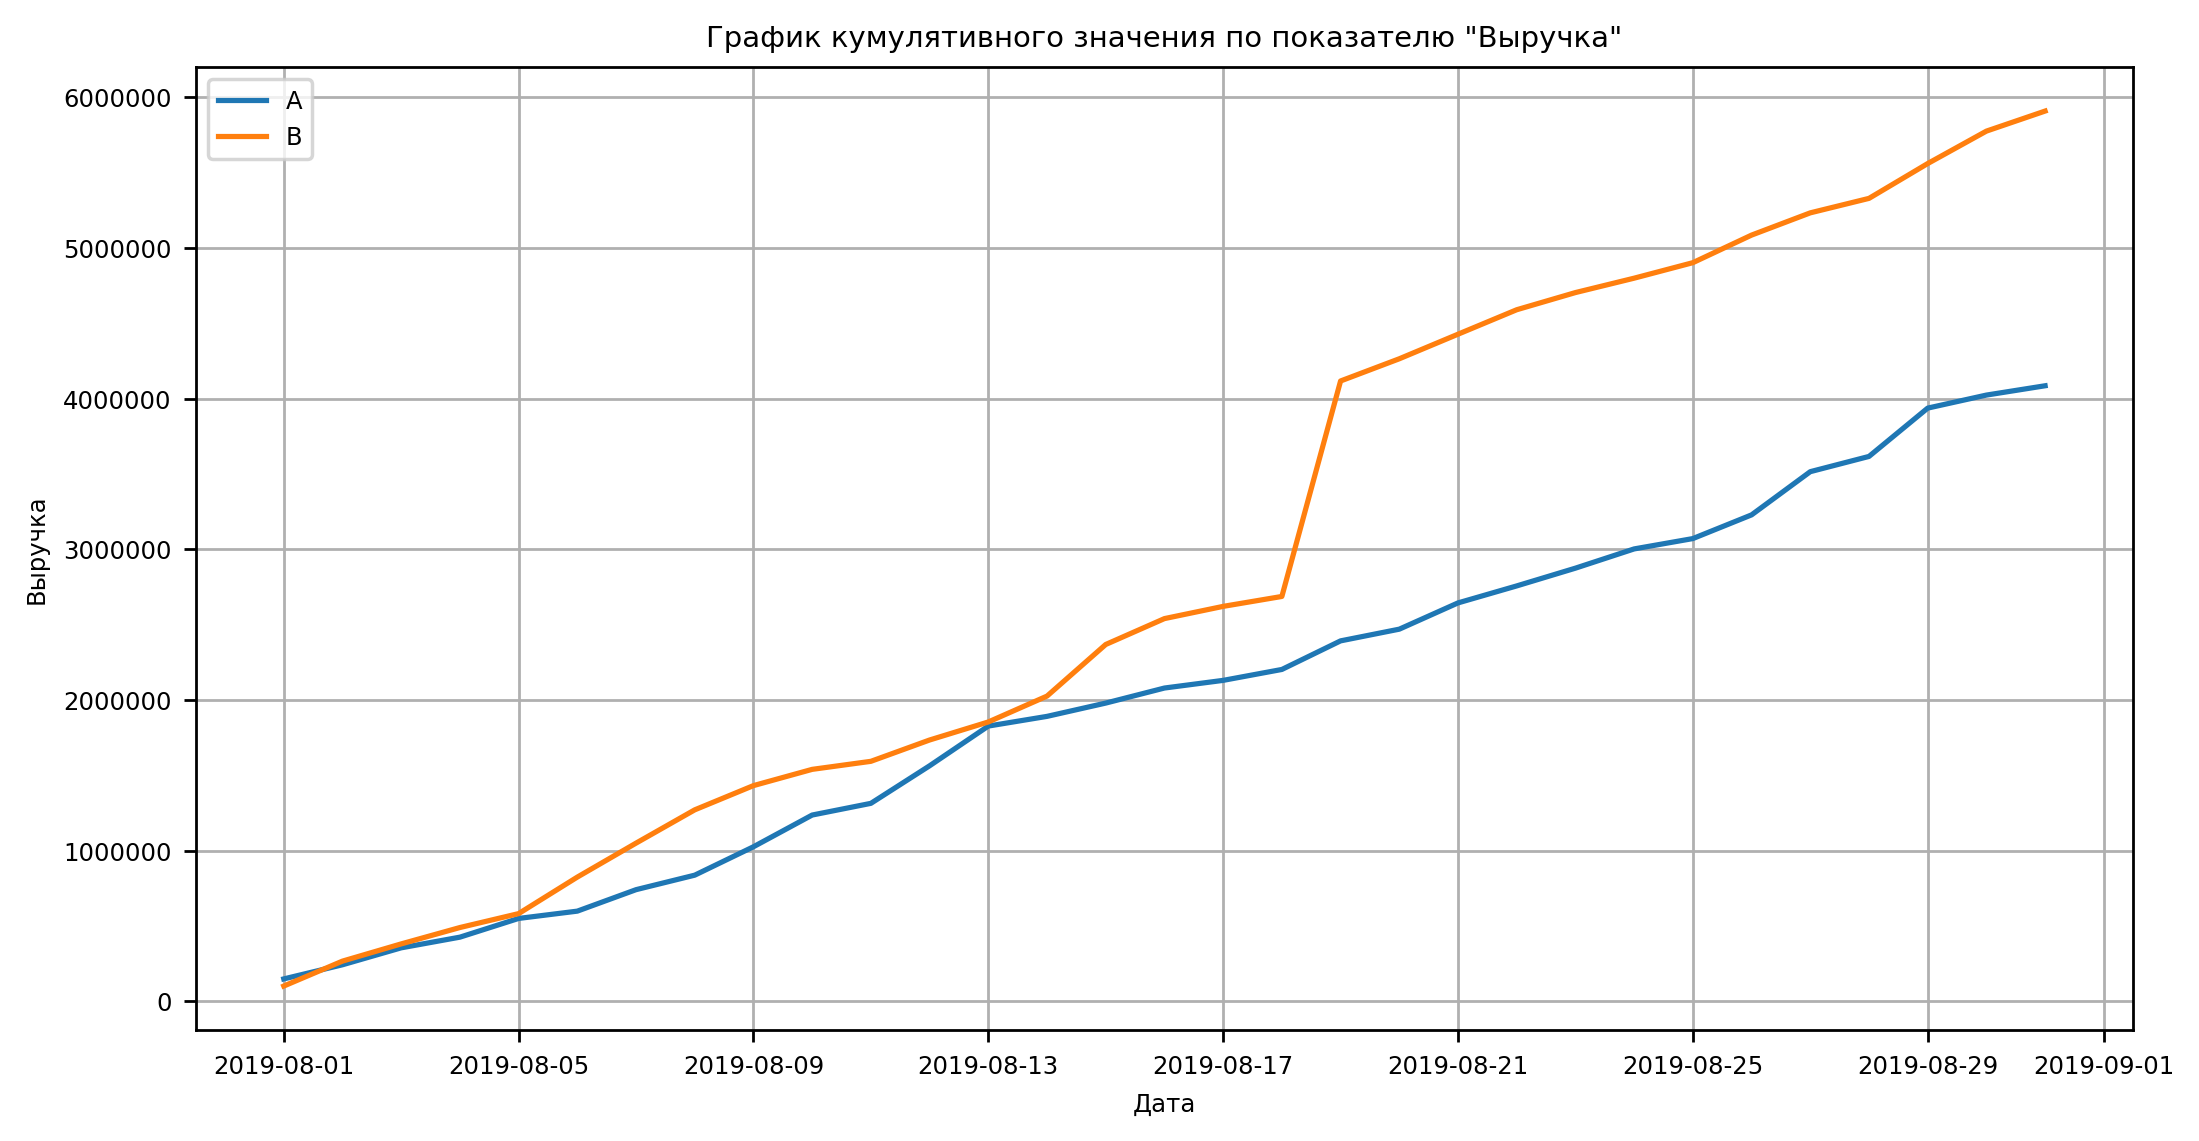

In [18]:
split_plot('revenue')

Выручка по обеим группам равномерно растет, и это хороший знак, это значит мы все сделали правильно. Выручка по группе B уверенно лидирует, однако, можем наблюдать по группе резкий скачок выручки между 17 и 23 августа, возможно дело в выбросах, это нам еще предстоит проверить чуть позже. 
А пока перейдем к среднему чеку.

#### Построение графиков по среднему чеку (avg_revenue)

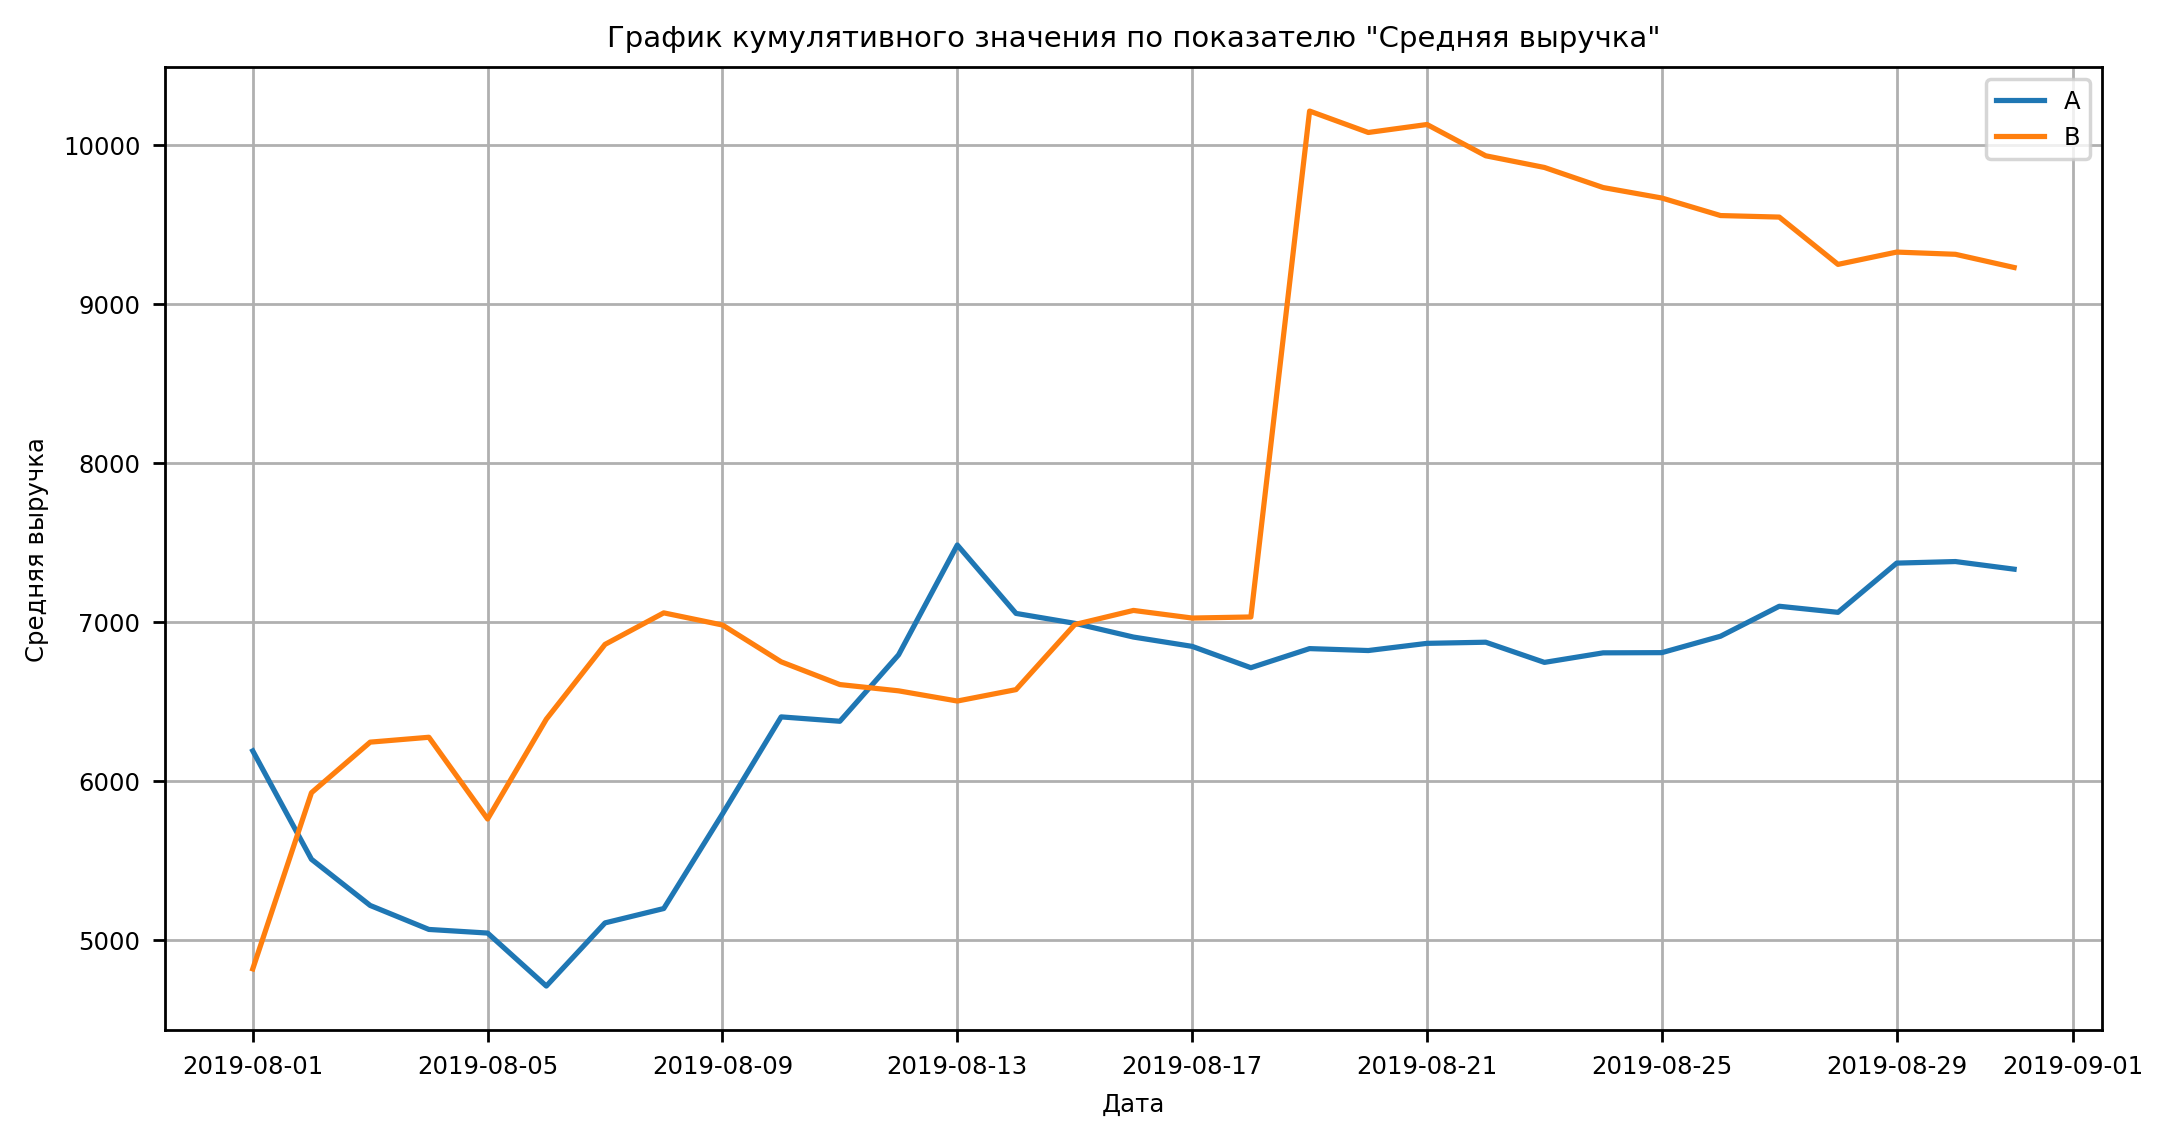

In [19]:
split_plot('avg_revenue')

Средний чек в первой половине теста скачет, равномерным становится ближе к концу теста, примерно после 19 августа: стабилен для группы A и падает для группы B.  
Возможно, дело наличии аномально крупных заказов, попавших в группу B (резкий всплеск на графике между 17 и 21 августа). Чтобы прийти к реальному среднему чеку и установиться на его уровне нужно больше данных.
Посмотрим на относительное изменение данного показателя.

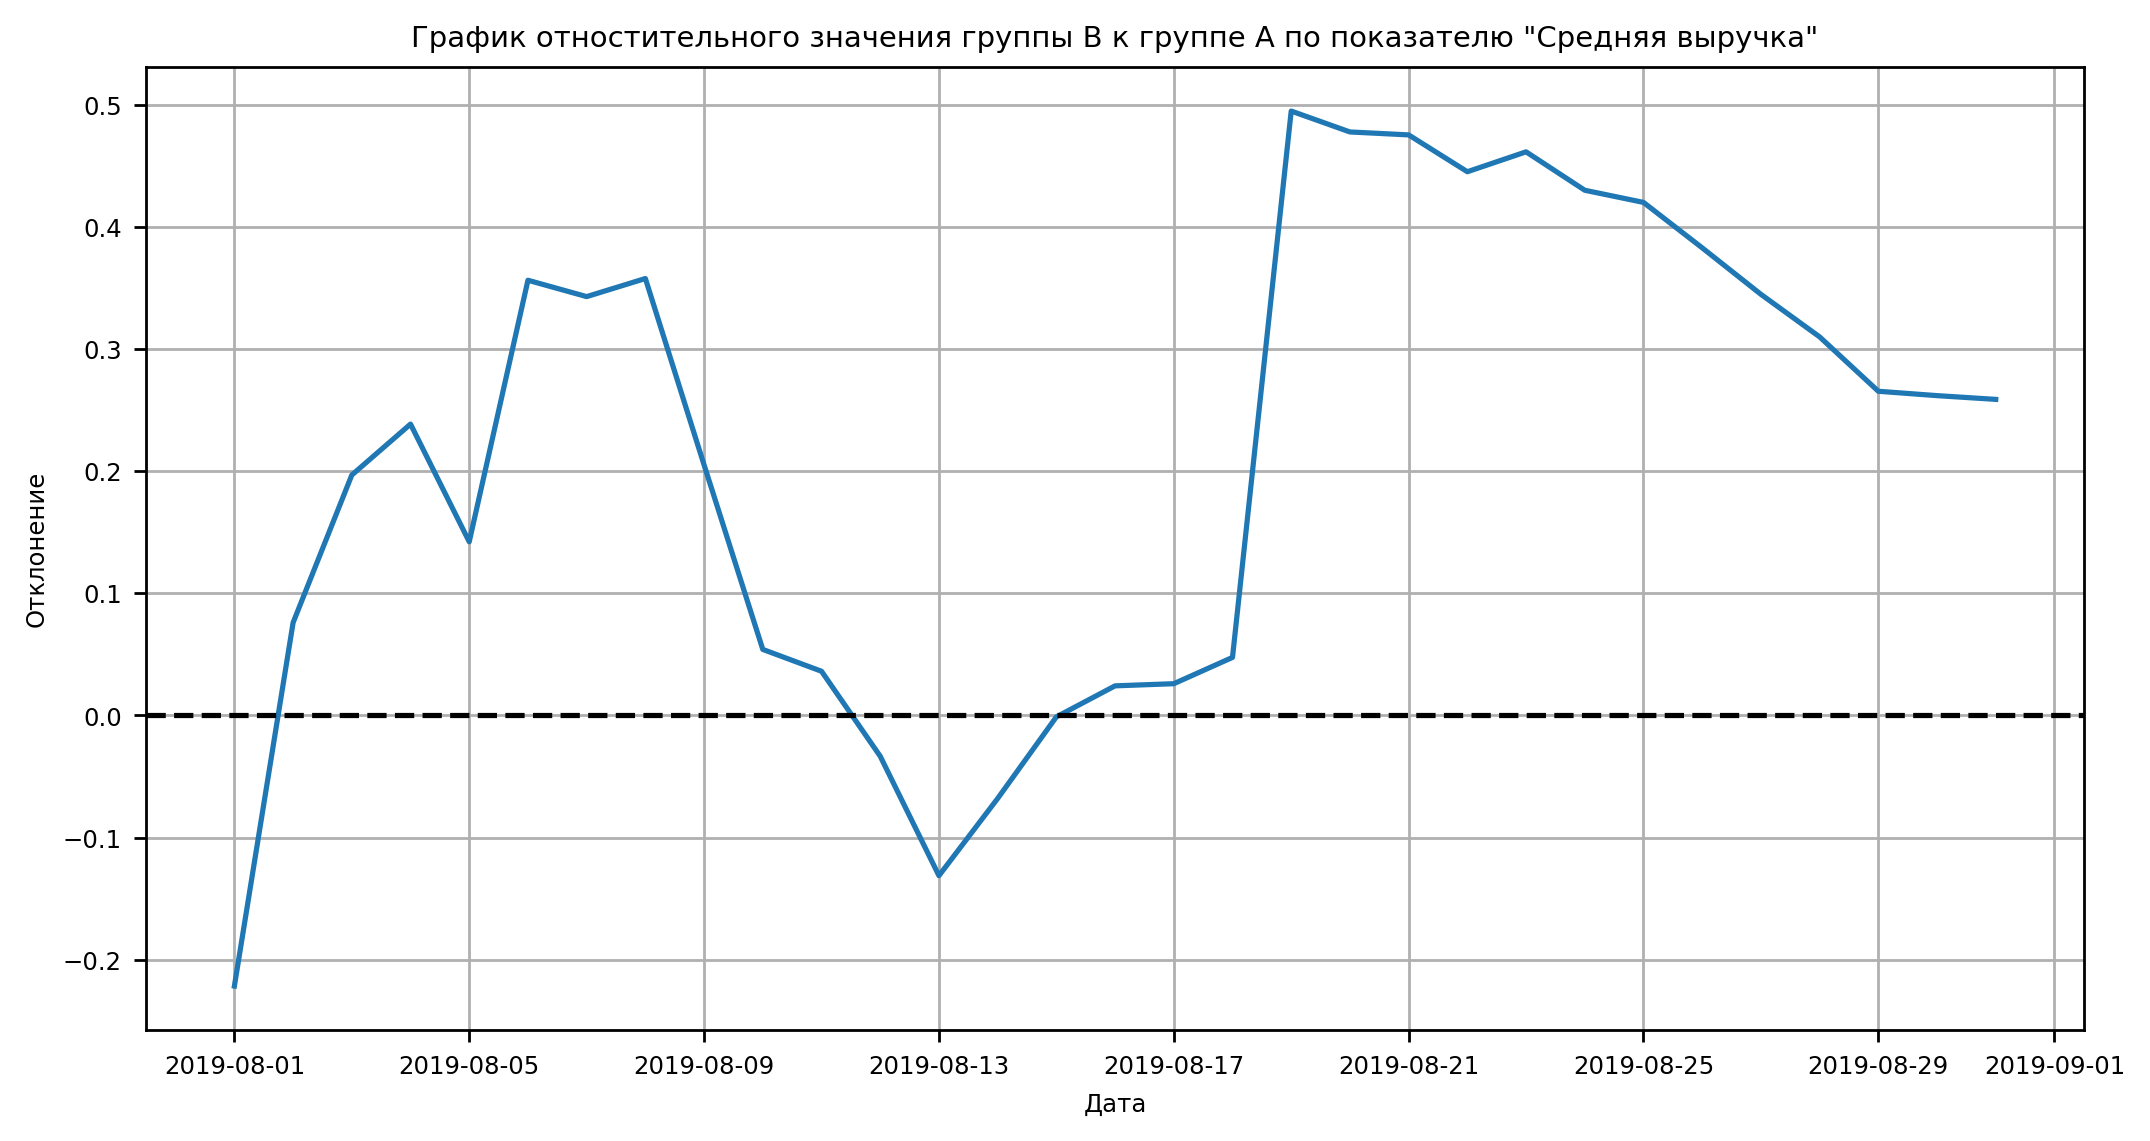

In [20]:
relative_plot('avg_revenue')

График скачет в нескольких местах, однако факт остается фактом, группа B существенно опережает A-группу со значительным отрывом. Насколько существенно на эту динамику влияют выбросы на текущем этапе сложно сказать.
Время конверсии!

#### Построение графиков по конверсии (conversion)

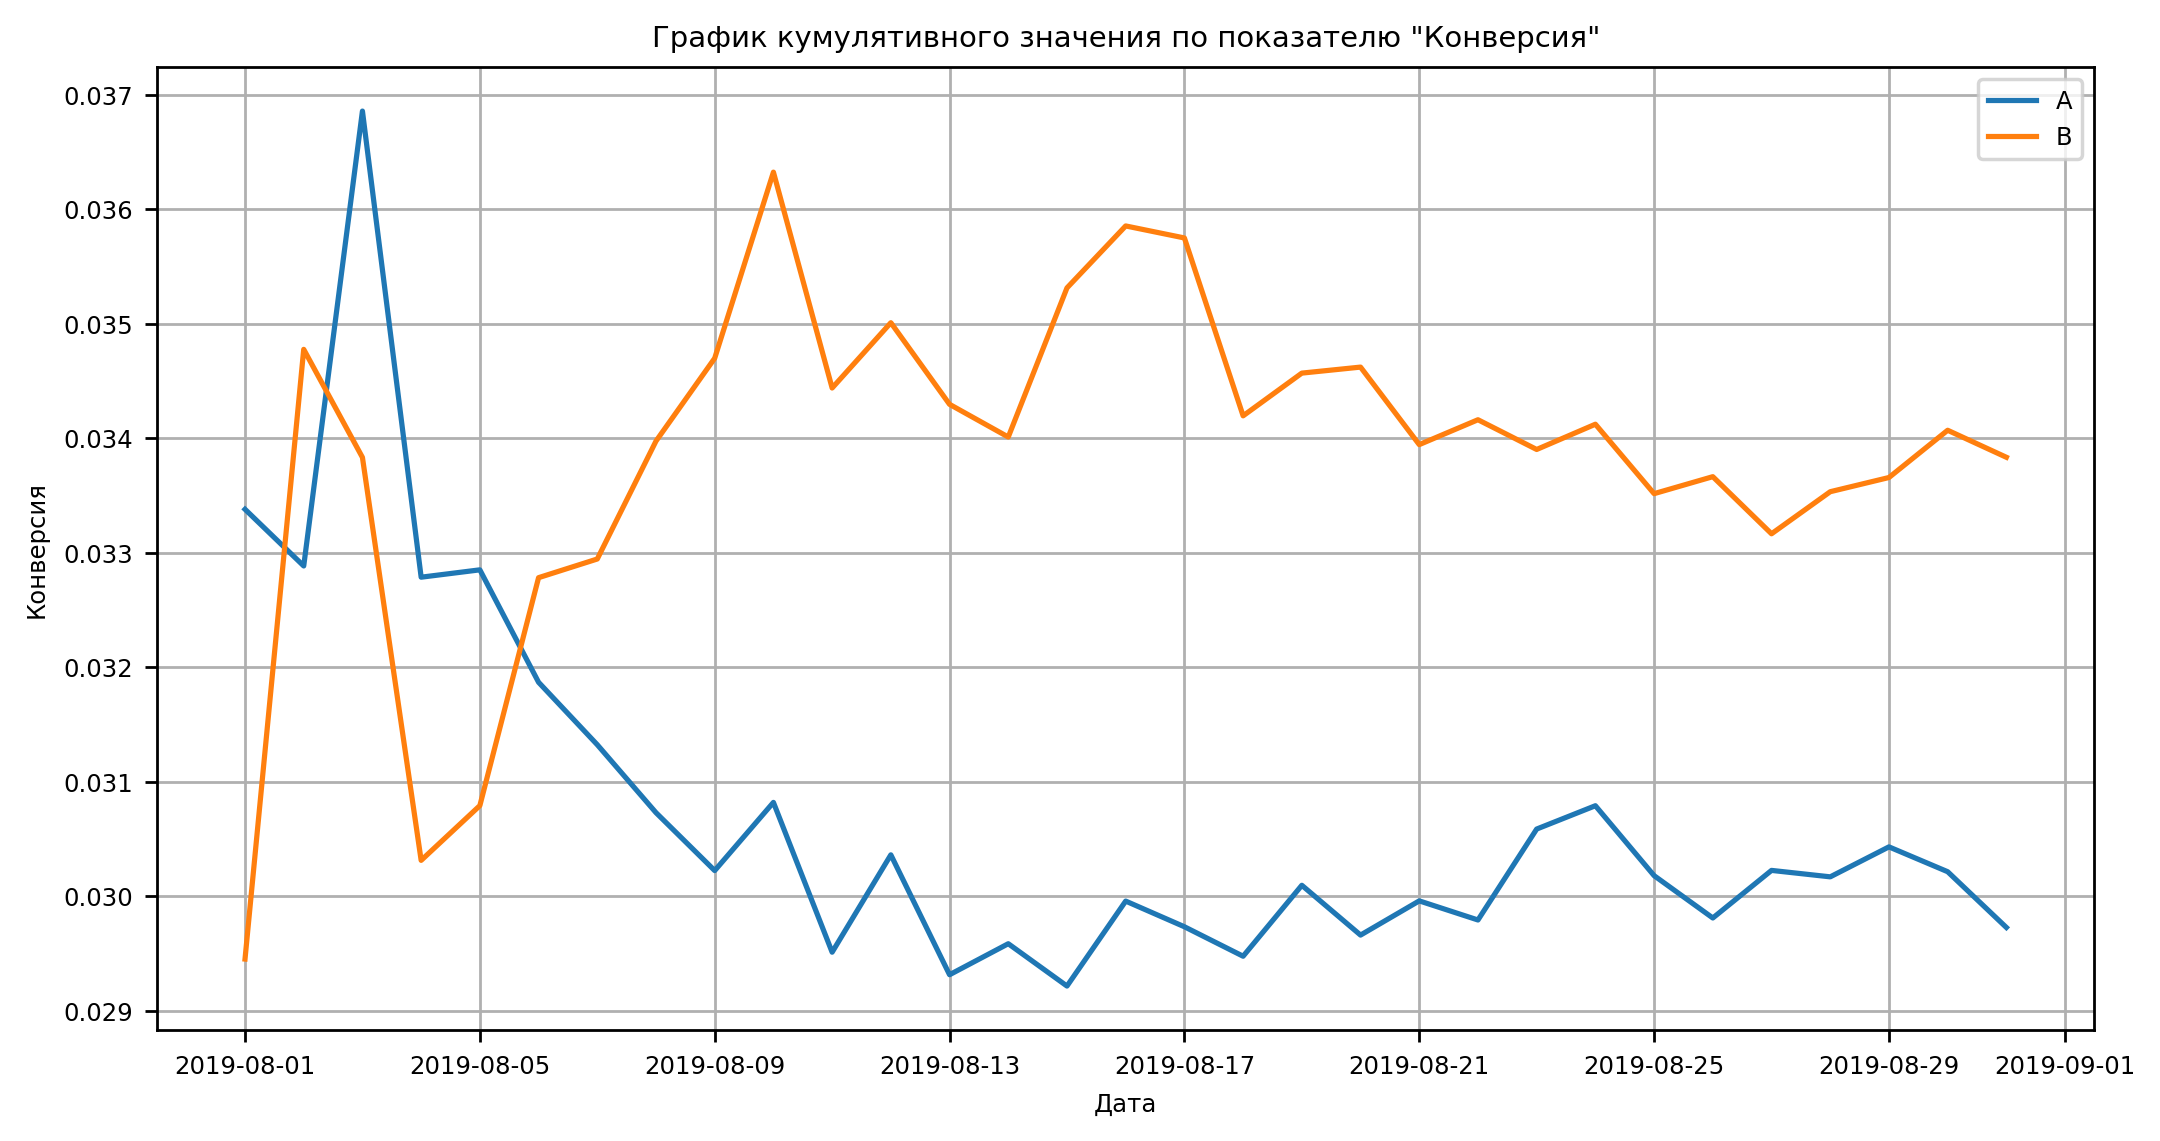

In [21]:
split_plot('conversion')

Получилось достаточно симметрично. Группы колебались около недели, но затем конверсия группы B вырвалась вперёд и к концу теста немного просела, а конверсия группы A сильно уменьшилась в период с 5 по 9 агуста, а далее на протяжении всего отрезка показывала себя достататочно стабильно с небольшим ростом. 
Посмотрим на график относительного различия кумулятивных конверсий.

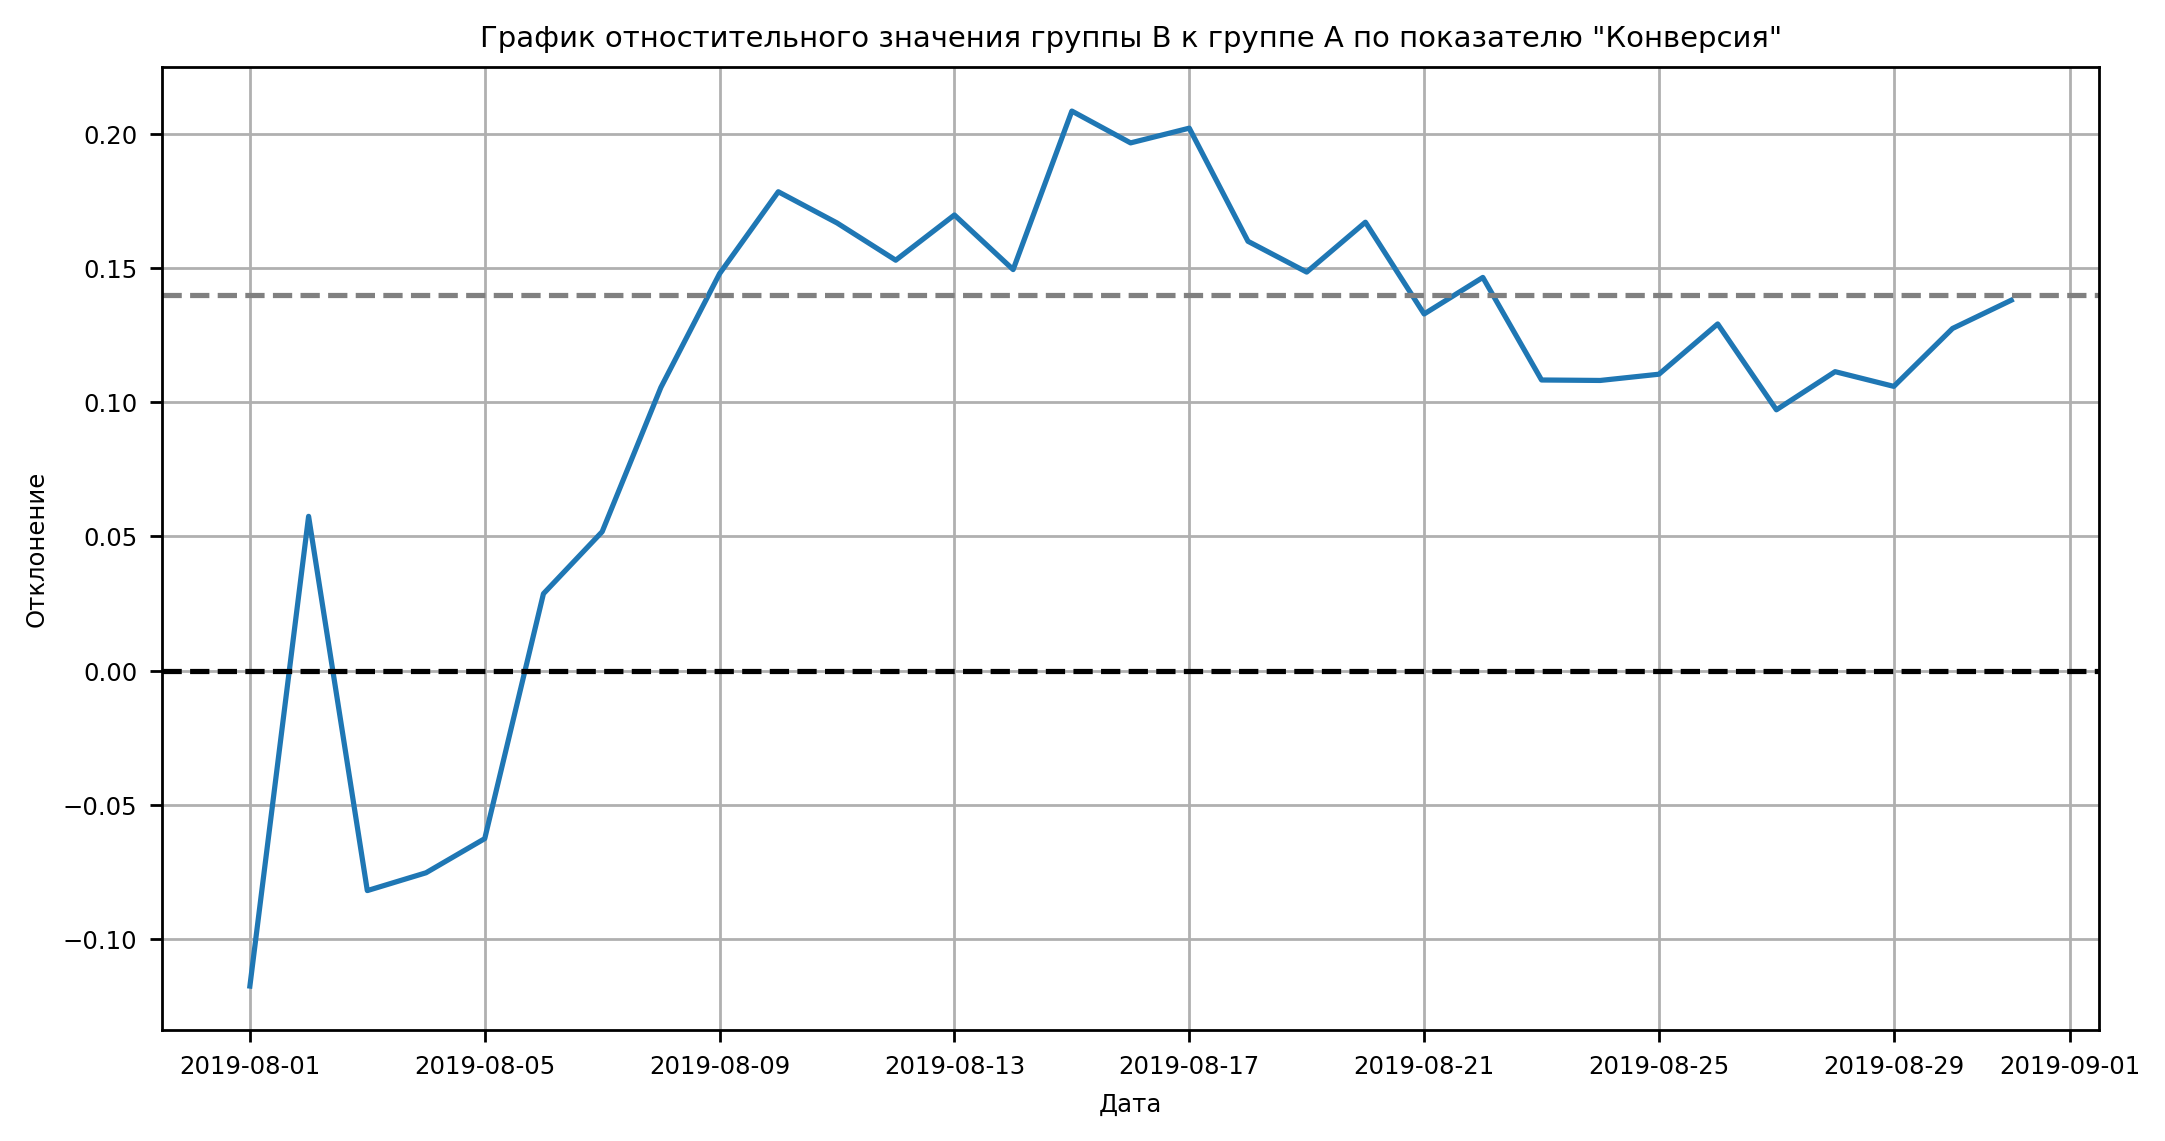

In [22]:
relative_plot('conversion', 0.14)

В начале теста конверсия по А была больше, однако после нескольких скачков группа B вырвалась вперёд. С ледующий период времени конверсия B  постепенно снижалась, но в самом конце теста мы видим положительную динамику B снова.
Выводы делать пока преждевременно, отношение конверсии ещё в целом не установилось.
Самое время проверить наши предположения относительно выбросов!

#### Анализ аномальных значений

Посмотрим на распределение выручки:

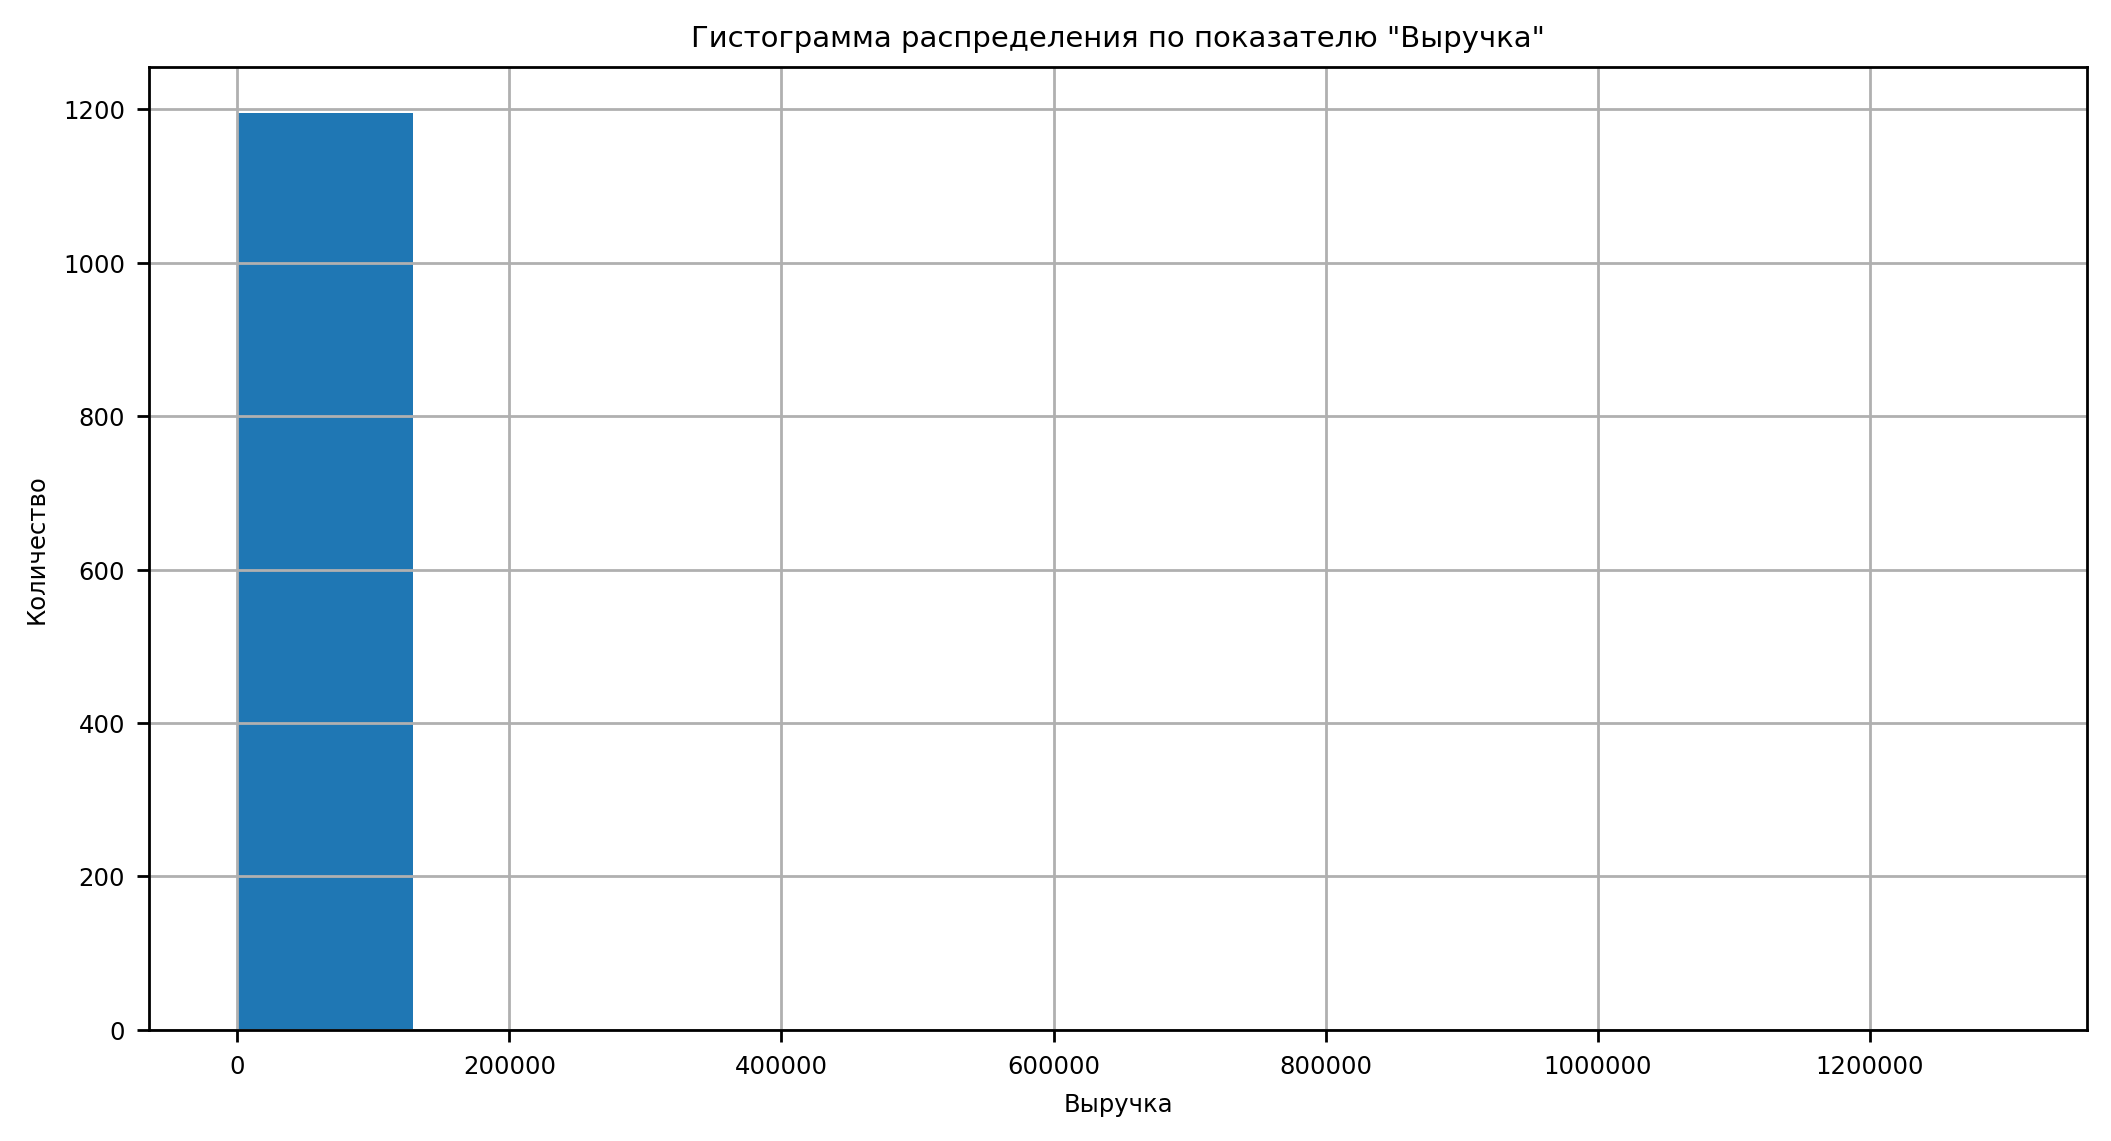

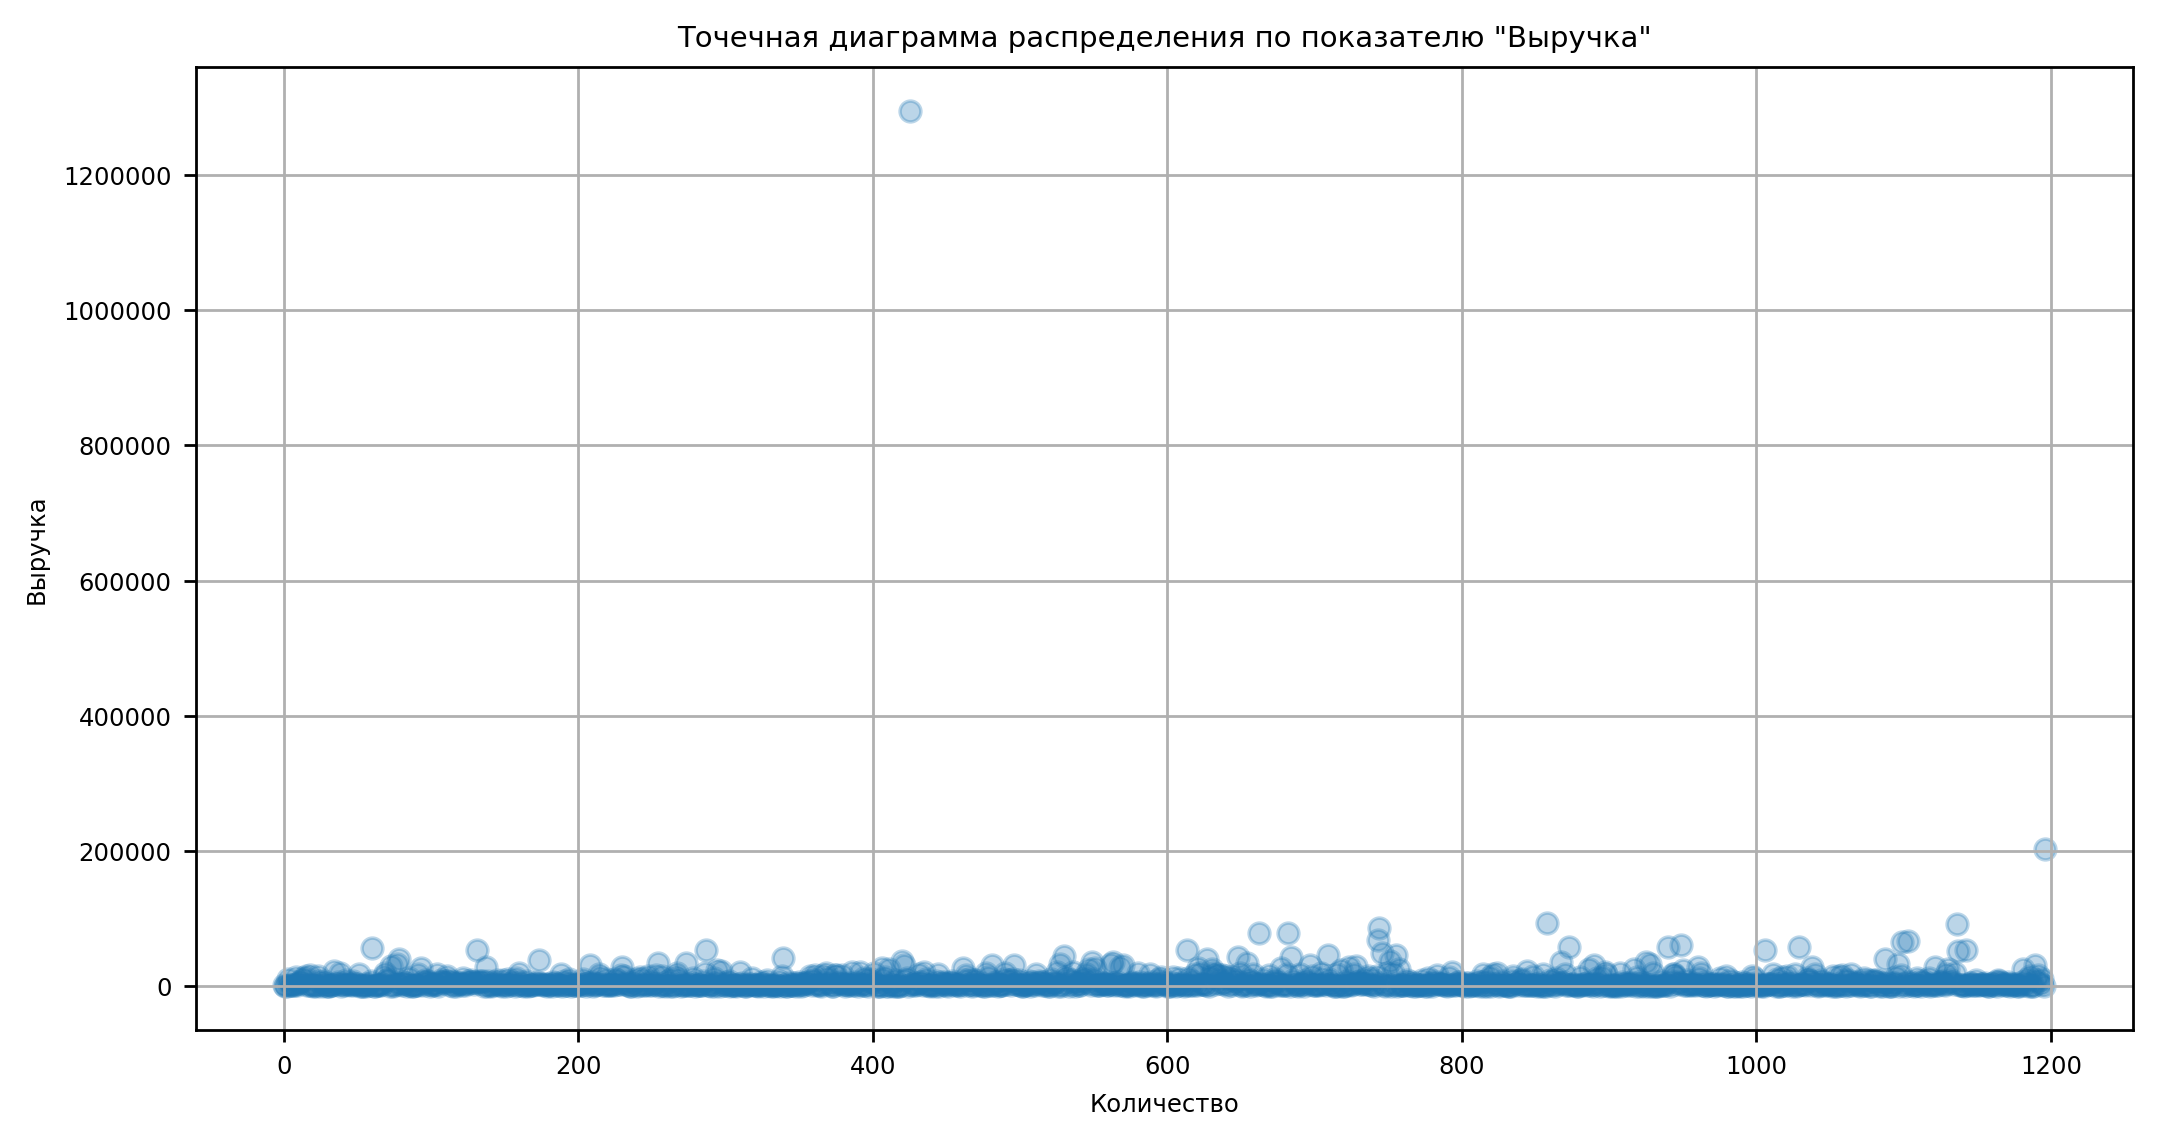

In [23]:
emissions_plot(orders, 'revenue')

На точечной диаграме видим два аномальных значения. Их точная доля не ясна, посчитаем 95-й и 99-й перцентили для определения границы аномальных значений.

In [24]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей. Значения которые мы выявили визуально выбросы с долей в районе статистической погрешности. 
Можно попробовать ограничить массив условием по выручке до 60 000 руб. чтобы отсечь аномальные значения.

Теперь посмотрим как обстоят дела с количеством заказов на одного пользователя:

In [25]:
# подготовим данные
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['user_id', 'orders']

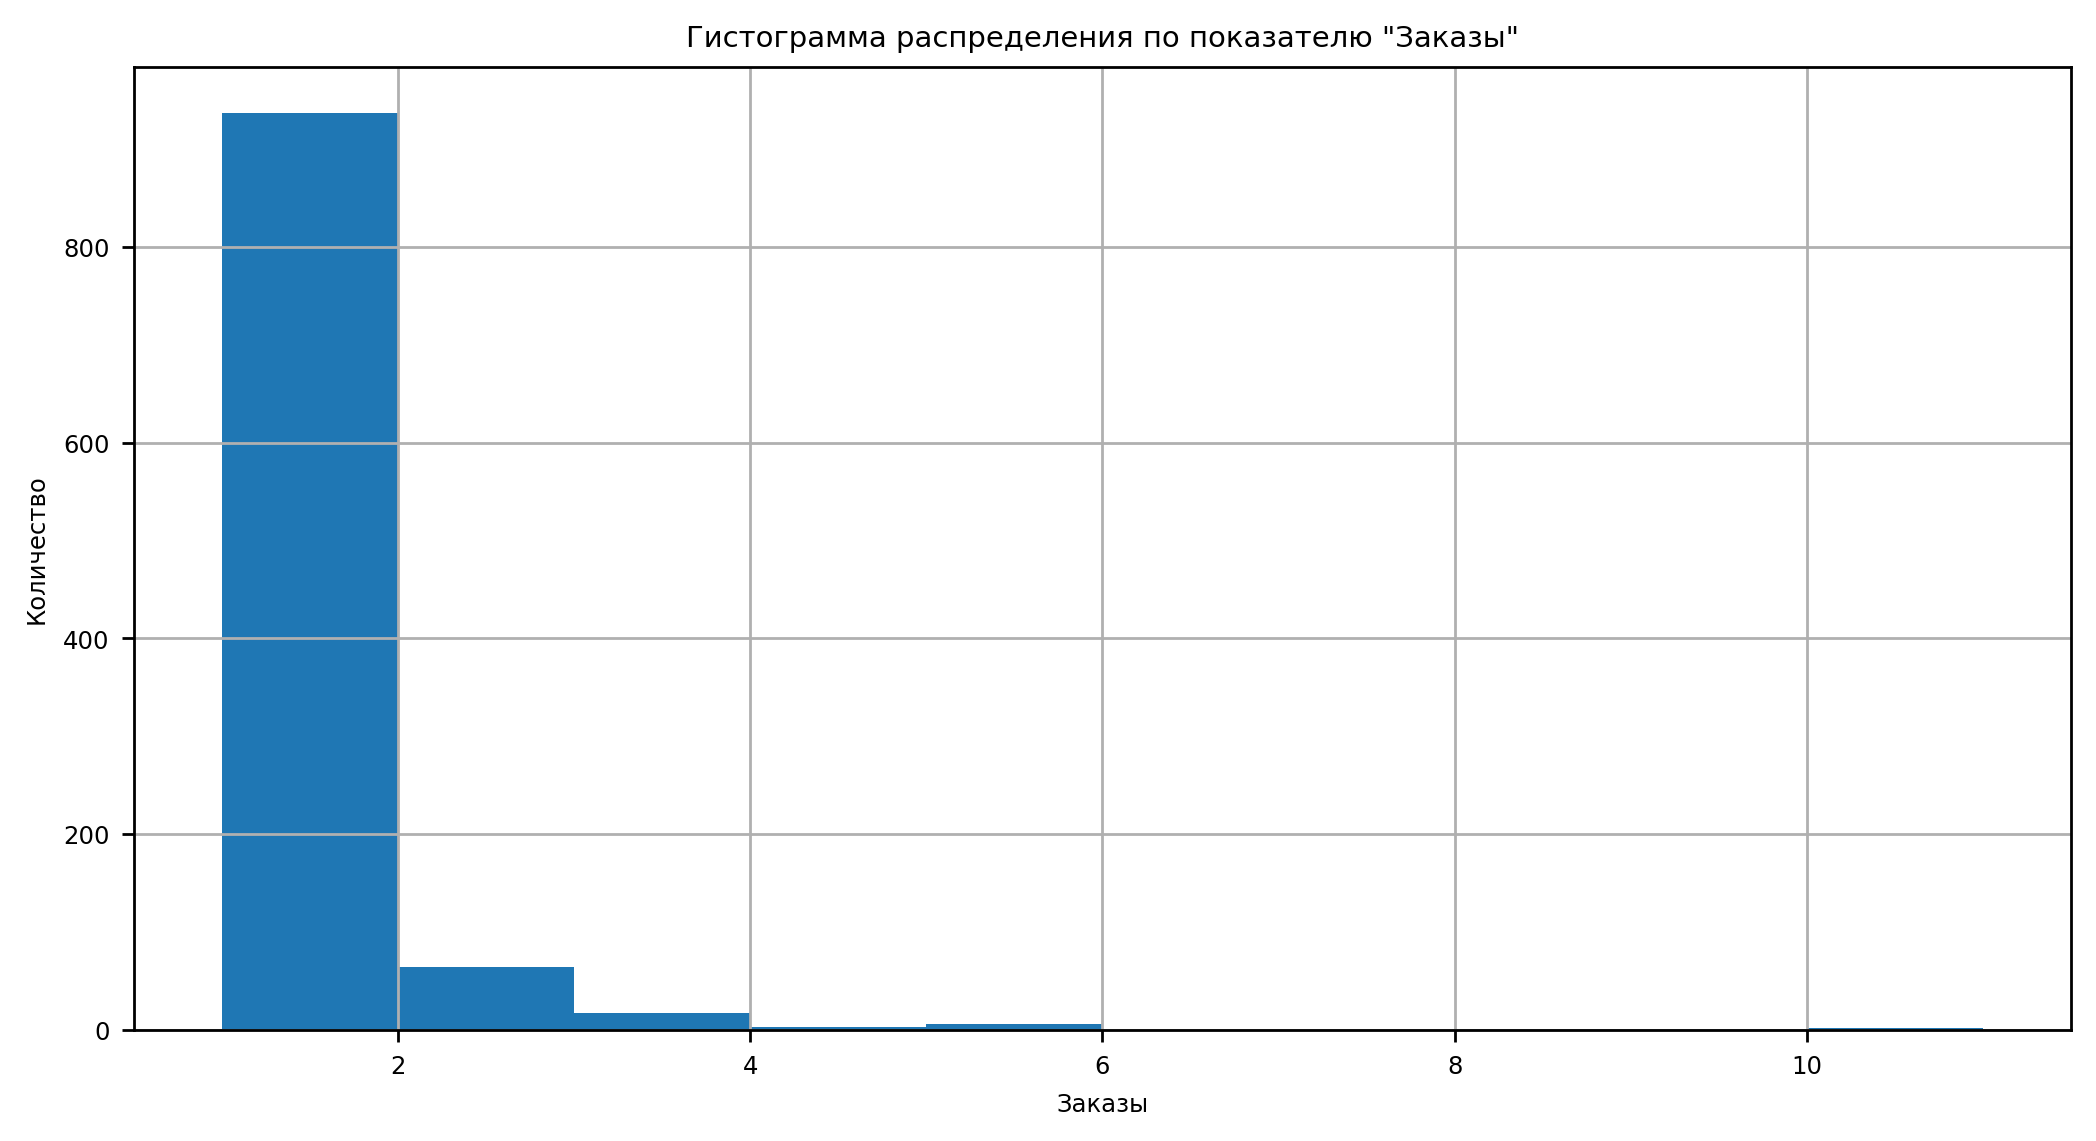

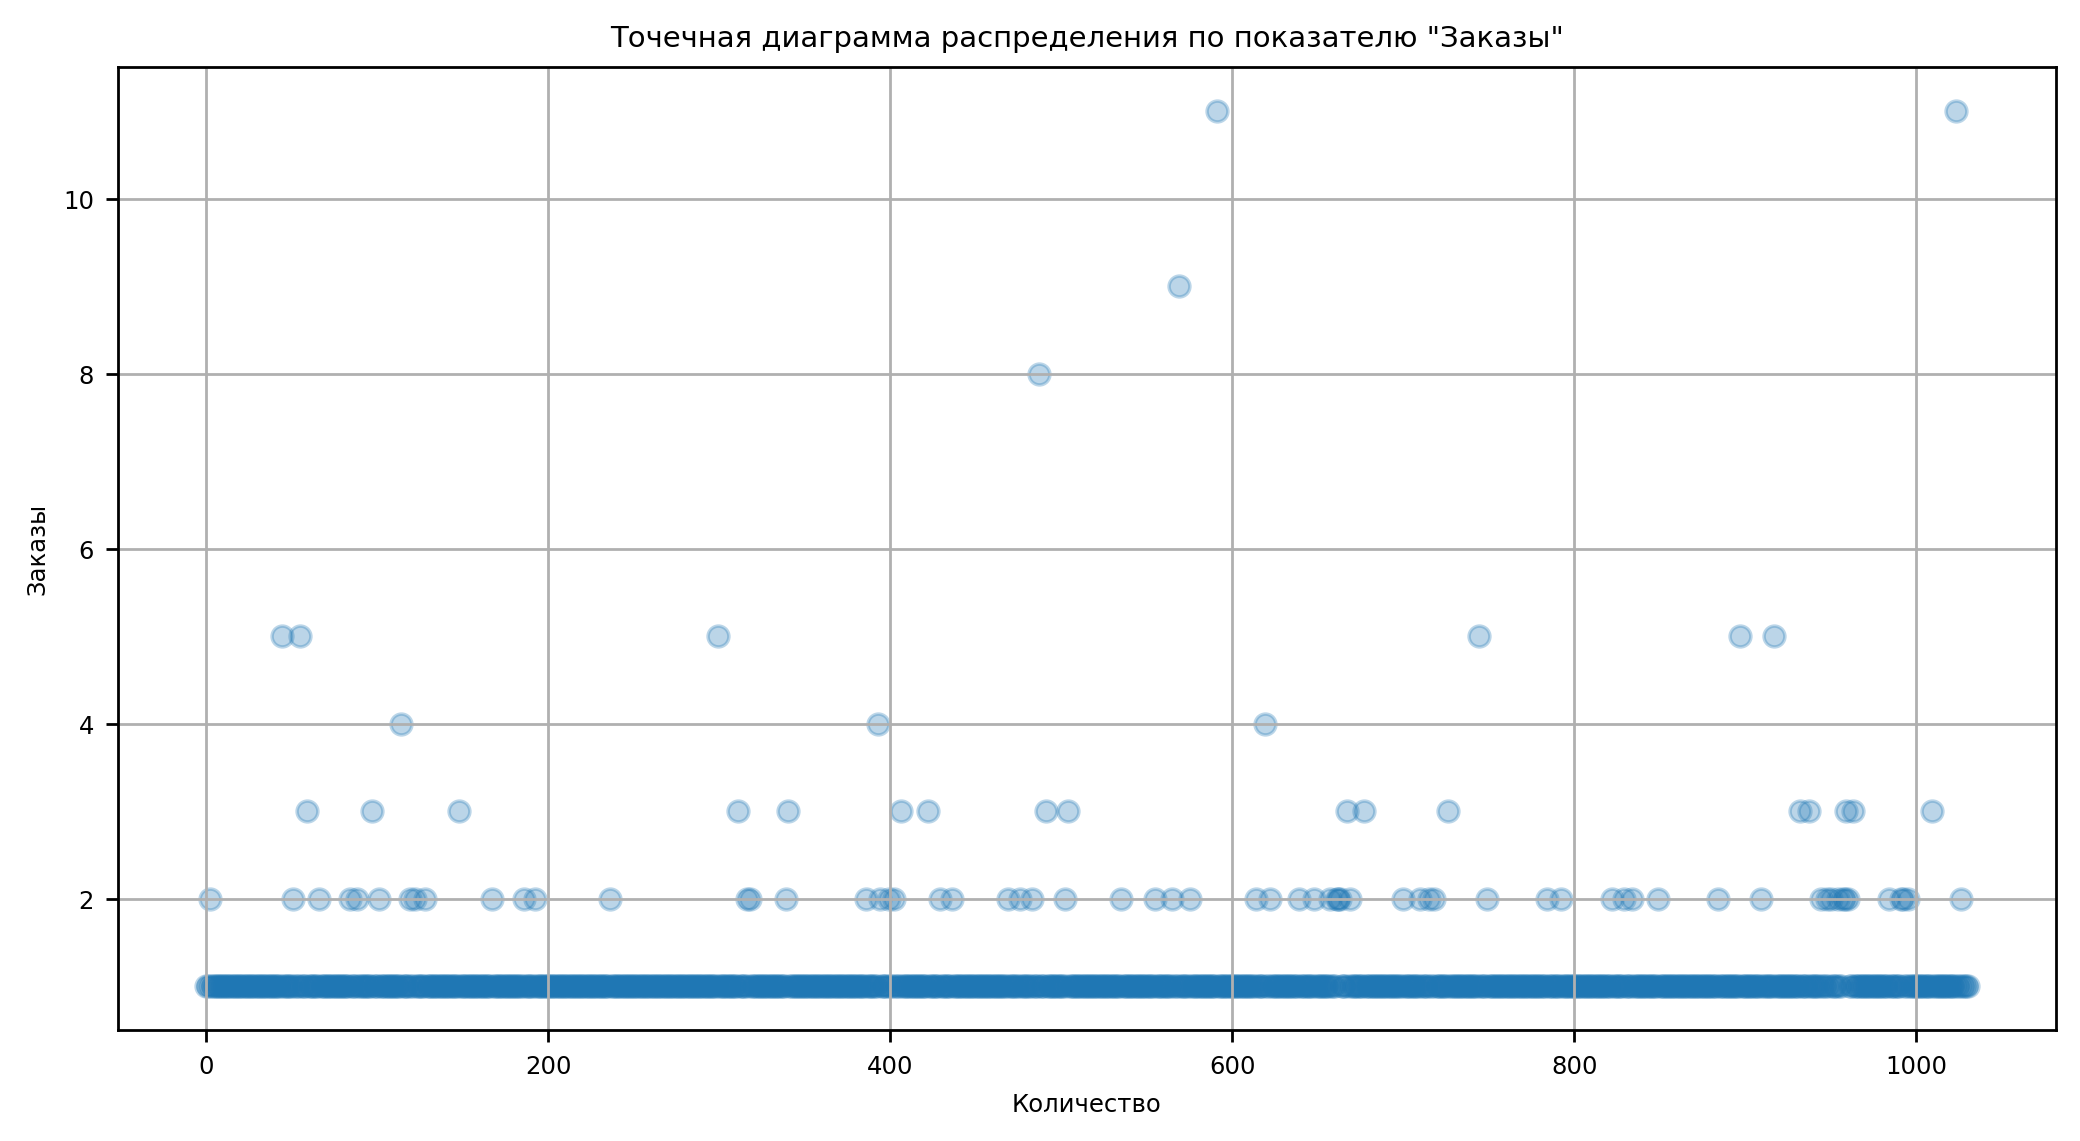

In [26]:
emissions_plot(orders_by_users, 'orders')

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами тоже значительна.
Для выбора границы определения аномальных пользователей, нам также понадобится расчет 95-го и 99-го перцентилей количества заказов на пользователя. 

In [27]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И 1% пользователей заказывали более четырех раз. 
Разумно выбрать не более 3 или 4 заказов на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

#### Расчет статистической значимости

Создаем датафрейм для оценки статистической значимости, где:
- date — дата;
- pd_ord_A — количество заказов в выбранную дату в группе A;
- pd_rev_A — суммарная выручка в выбранную дату в группе A;
- pd_ord_B — количество заказов в выбранную дату в группе B;
- pd_rev_B — суммарная выручка в выбранную дату в группе B;
- cmlt_ord_A — суммарное число заказов до выбранной даты включительно в группе A;
- cmlt_rev_A — суммарная выручка до выбранной даты включительно в группе A;
- cmlt_ord_B — суммарное количество заказов до выбранной даты включительно в группе B;
- cmlt_rev_B — суммарная выручка до выбранной даты включительно в группе B;
- pd_vis_A — количество пользователей в выбранную дату в группе A;
- pd_vis_B — количество пользователей в выбранную дату в группе B;
- cmlt_vis_A — количество пользователей до выбранной даты включительно в группе A;
- cmlt_vis_B — количество пользователей до выбранной даты включительно в группе B.

In [28]:
# считаем данные по таблице visitors, по дням и кумулятивно
    #A
daily_vis_A = visitors[visitors.group == 'A'][['date', 'visitors']]
daily_vis_A.columns = ['date', 'pd_vis_A']

cmlt_vis_A = daily_vis_A.apply(
    lambda x: daily_vis_A[daily_vis_A.date <= x.date].agg(
        {'date': 'max', 'pd_vis_A': 'sum'}
    ),
    axis=1,
)
cmlt_vis_A.columns = ['date', 'cmlt_vis_A']

     #B
daily_vis_B = visitors[visitors.group == 'B'][['date', 'visitors']]
daily_vis_B.columns = ['date', 'pd_vis_B']

cmlt_vis_B = daily_vis_B.apply(
    lambda x: daily_vis_B[daily_vis_B.date <= x.date].agg(
        {'date': 'max', 'pd_vis_B': 'sum'}
    ),
    axis=1,
)
cmlt_vis_B.columns = ['date', 'cmlt_vis_B']

# считаем данные по таблице orders, по дням и кумулятивно
    #A
daily_ord_A = (
    orders[orders.group == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
daily_ord_A.columns = ['date', 'pd_ord_A', 'pd_rev_A']

cmlt_ord_A = daily_ord_A.apply(
    lambda x: daily_ord_A[daily_ord_A.date <= x.date].agg(
        {'date': 'max', 'pd_ord_A': 'sum', 'pd_rev_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
cmlt_ord_A.columns = [
    'date',
    'cmlt_ord_A',
    'cmlt_rev_A',
]

    #B
daily_ord_B = (
    orders[orders.group == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
daily_ord_B.columns = ['date', 'pd_ord_B', 'pd_rev_B']

cmlt_ord_B = daily_ord_B.apply(
    lambda x: daily_ord_B[daily_ord_B.date <= x.date].agg(
        {'date': 'max', 'pd_ord_B': 'sum', 'pd_rev_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
cmlt_ord_B.columns = [
    'date',
    'cmlt_ord_B',
    'cmlt_rev_B',
]

# обьединяем в единый датафрейм
data = (
    daily_ord_A.merge(
        daily_ord_B, left_on='date', right_on='date', how='left')\
        .merge(cmlt_ord_A, left_on='date', right_on='date', how='left')
        .merge(cmlt_ord_B, left_on='date', right_on='date', how='left')
        .merge(daily_vis_A, left_on='date', right_on='date', how='left')
        .merge(daily_vis_B, left_on='date', right_on='date', how='left')
        .merge(cmlt_vis_A, left_on='date', right_on='date', how='left')
        .merge(cmlt_vis_B, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,pd_ord_A,pd_rev_A,pd_ord_B,pd_rev_B,cmlt_ord_A,cmlt_rev_A,cmlt_ord_B,cmlt_rev_B,pd_vis_A,pd_vis_B,cmlt_vis_A,cmlt_vis_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим переменные 'ord_bu_A' и 'ord_bu_B' со столбцами 'visitor_id' и 'orders'. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.  
А для подготовки выборки к проверке критерием Манна-Уитни, объявим переменные 'sample_A' и 'sample_B', в которых пользователям из разных групп будет соответствовать количество заказов.

In [29]:
ord_bu_A = (
    orders[orders.group == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ord_bu_A.columns = ['visitor_id', 'orders']

ord_bu_B = (
    orders[orders.group == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ord_bu_B.columns = ['visitor_id', 'orders']

sample_A = pd.concat(
    [
        ord_bu_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['pd_vis_A'].sum() - len(ord_bu_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B = pd.concat(
    [
        ord_bu_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['pd_vis_B'].sum() - len(ord_bu_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

##### По "сырым данным"

**Cтатистическая значимость различий в среднем количестве заказов:**

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.  
Нулевая гипотеза: различий в среднем числе заказов между группами нет.   
Альтернативная гипотеза: различия в среднем числе заказов между группами есть.

In [30]:
print("P-value: {0:.3f}".format(st.mannwhitneyu(sample_A, sample_B)[1]))

print("Прирост B по отношению к A: {0:.1f}%".format((sample_B.mean() / sample_A.mean() - 1)*100))

P-value: 0.017
Прирост B по отношению к A: 13.8%


Вывод: По «сырым» данным мы обнаружили различие в среднем числе заказов групп A и B. 
p-value = 0.017 что меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем, различия есть и они статистически значимые.   
Относительный прирост группы B равен 13.8%.

**Статистическая значимость различий в среднем чеке:**

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 
Нулевая гипотеза: различий в среднем чеке между группами нет. 
Альтернативная гипотеза: различия в среднем чеке между группами есть. 
Также найдём относительные различия в среднем чеке между группами:

In [31]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(orders[orders.group =='A']['revenue'],
                                          orders[orders.group =='B']['revenue'])[1]
                      )
     )
print('Прирост B по отношению к A: {0:.1f}%'.format(orders[orders.group =='B']['revenue'].mean()/
                       orders[orders.group =='A']['revenue'].mean()-1
                      )
     )

P-value: 0.729
Прирост B по отношению к A: 0.3%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы В значительно выше среднего чека группы A.

##### По "очищенным" данным

Для начала узнаем, сколько всего аномальных пользователей:

In [32]:
m_ord_users = pd.concat(
    [
        ord_bu_A[ord_bu_A.orders > 3]['visitor_id'],
        ord_bu_B[ord_bu_B.orders > 3]['visitor_id'],
    ],
    axis=0,
)
e_ord_users = orders[orders.revenue > 60000]['visitor_id']

abnormal_users = (
    pd.concat([m_ord_users, e_ord_users], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
Name: visitor_id, dtype: int64
19


Всего 19 аномальных пользователей.   
Посмотрим как они повлияли на результаты теста.  
Но сначала подготовим выборки количества заказов по пользователям по группам теста:

In [33]:
sample_A_f = pd.concat(
    [
        ord_bu_A[
            np.logical_not(ord_bu_A.visitor_id.isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data.pd_vis_A.sum() - len(ord_bu_A.orders)
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_f = pd.concat(
    [
        ord_bu_B[
            np.logical_not(ord_bu_B.visitor_id.isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data.pd_vis_B.sum() - len(ord_bu_B.orders)
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

**Cтатистическая значимость различий в среднем количестве заказов:**

In [34]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(sample_A_f, sample_B_f)[1]))
print('Прирост B по отношению к A: {0:.1f}%'.format(sample_B_f.mean()/sample_A_f.mean()-1))

P-value: 0.013
Прирост B по отношению к A: 0.2%


Результаты по среднему количеству заказов практически не изменились.  
Сегмент B по прежнему значительно лучше сегмента А.

**Статистическая значимость различий в среднем чеке**

И наконец считаем статистическую значимость различий в среднем чеке по «очищенным» данным.

In [35]:
print(
    'P-value: {0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders.group == 'A',
                    np.logical_not(orders.visitor_id.isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders.group == 'B',
                    np.logical_not(orders.visitor_id.isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Прирост B по отношению к A: {0:.2f}%".format(
        orders[
            np.logical_and(
                orders.group == 'B',
                np.logical_not(orders.visitor_id.isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders.group == 'A',
                np.logical_not(orders.visitor_id.isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.921
Прирост B по отношению к A: -0.00%


P-value увеличился, но и разница между сегментами сократилась с 26% до 0,0%.
Хотя общие выводы по результатам теста не изменились, на этом примере видно как аномалии могут влиять на результаты A/B-теста

### Вывод:

В рамках анализа теста мы определили отличия между группами и проанализировали полученные результаты. В частности, касаемо динамики выручки было отмечено увеличение показателя по группе B, а также существенный перевес по среднему чеку B-группы и существенное преимущество по показателю конверсии также по группе B по практически на всем протяжении тестирования.  
  
Также рассмотрели возможность влияния аномальных значений на результат, выявили и устранили аномальные значения и сравнили значения статистической значимости до и после "очистки" данных от аномальных значений.
У нас есть основания отвергнуть нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, различия в среднем числе заказов есть и они статистически значимые.
При этом причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, у нас нет. Отметили также что, средний чек группы В значительно выше среднего чека группы A.
  
Итогом проведенного анализа явилось наличие статистически значимого влияния на среднее число заказов, и отсутствие такового при анализе различий в среднем чеке.
При этом разница между сегментами сократилась с 26% до 0,1%, за счет исключения аномальных значений из рассматриваемой совокупности.  

С учетом приведенных аргументов считаем целесообразным остановить тест и зафиксировать победу группы B, с учетом наличия существенного перевеса по выручке, среднему чеку и конверсии.

## Выводы

По результатам проведенного исследования были изучены данные касательно гипотез, заказов и данных пользователей.
Качество представленных данных оценено как высокое, предобработке подверглись лишь косметические параметры датафреймов, такие как названия колонок и формат столбцов содержащий дату.

На первом этапе анализа проведена приоритизация гипотез на базе фреймворков ICE и RICE, выявлены отличия методик и определен перечень приоритеных гипотез.  
Среди самых приоритетных мы отметили 7,2,0 и 6 гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию. 
  
Отметили, что в рамках приоритизации показатель охвата имеет решающее но не определяющее значение. Показатель необходимо учитывать, но даже при существенном охвате в случае низкого влияния, уверенности или больших затрат, гипотеза может и не иметь высокий приоритет.

На втором этапе мы рассмотрели результаты проведенного А/B тестирования.
Мы подготовили данные и сформировали функции для построения требуемых нам графиков и диаграмм.  
касаемо динамики выручки было отмечено увеличение показателя по группе B, а также существенный перевес по среднему чеку B-группы и существенное преимущество по показателю конверсии также по группе B по практически на всем протяжении тестирования.
Мы отвергли нулевую гипотезу и подтвердили наличие статистически значимых различий в среднем числе заказов между группами,  Гипотеза в среднем чеке есть различия не подтвердилась. Отметили также что, средний чек группы В значительно выше среднего чека группы A.
При этом отмечаем что за счет исключения аномальных значений из рассматриваемой совокупности удалось сократить разницу между сегментами в части среднего чека с 26% до 0,1%.

Таким образом, с учетом проведенной работы, мы приняли решение остановить тест и зафиксировать победу группы B, с учетом наличия существенного перевеса по выручке, среднему чеку и конверсии.